In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

It would be interesting to find out the connection between emergency visits in the year before the hospitalization and such features  as race, gender, age, admission type, time in hospital and  HbA1c test results.

In [2]:
data = pd.read_csv(open("dataset_diabetes/diabetic_data.csv"))
n_samples = data.shape[0]

In [3]:
print ('Number of samples', n_samples)

Number of samples 101766


## Emergency visits

In [57]:
#Number of emergency visits of the patient in the year preceding the encounter

n_emergency = np.asarray(data['number_emergency'])
emergency_values = np.unique(n_emergency)

In [58]:
#Age intervals, for example [10, 20)

ages = np.asarray(data["age"])
ages_types = np.unique(ages)

In [59]:
probability = []
for age in ages_types:
    emergency = n_emergency[np.where(ages == age)]
    probability.append(emergency.sum() / len(emergency))
    print(age, emergency.sum() / len(emergency))

[0-10) 0.0310559006211
[10-20) 0.156295224313
[20-30) 0.578153289077
[30-40) 0.490331125828
[40-50) 0.356840474961
[50-60) 0.222473342605
[60-70) 0.162433838901
[70-80) 0.13108025165
[80-90) 0.144269349305
[90-100) 0.13104189044


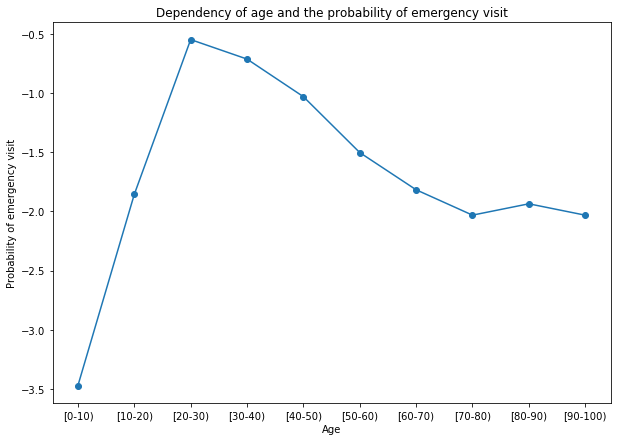

In [60]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(len(ages_types)), np.log(probability), marker='o')
plt.xticks(np.arange(len(ages_types)), ages_types)
plt.title("Dependency of age and the probability of emergency visit")
plt.xlabel("Age")
plt.ylabel("Probability of emergency visit")

### LabelEncoding

In [4]:
LE = LabelEncoder()

In [5]:
data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
s = 0
for column in data.columns:
    LE.fit(data[column])
    data[column] = LE.transform(data[column])
    s += 1

In [7]:
X, y = np.asarray(data[data.columns[2:-1]]), np.asarray(data['readmitted'])

### Data split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

### Label binarization

In [9]:
print ('Label encoding for readmitted', LE.classes_)

Label encoding for readmitted ['<30' '>30' 'NO']


In [10]:
y_bin_train = np.zeros(len(y_train))
y_bin_test = np.zeros(len(y_test))

for i in range(len(y_train)):
    if y_train[i] < 2:
        y_bin_train[i] = 1
    else:
        y_bin_train[i] = 0
        
for i in range(len(y_test)):
    if y_test[i] < 2:
        y_bin_test[i] = 1
    else:
        y_bin_test[i] = 0


### Only readmitted and non readmitted classification (Binary classification)

In [ ]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_bin_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print ('Accuracy', list(clf.predict(X_test) == y_bin_test).count(True) / len(y_bin_test))

### PCA to visualize

In [18]:
n_components = 2

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("PCA is done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Transformation is done in %0.3fs" % (time() - t0)

Projecting the input data on the eigenfaces orthonormal basis


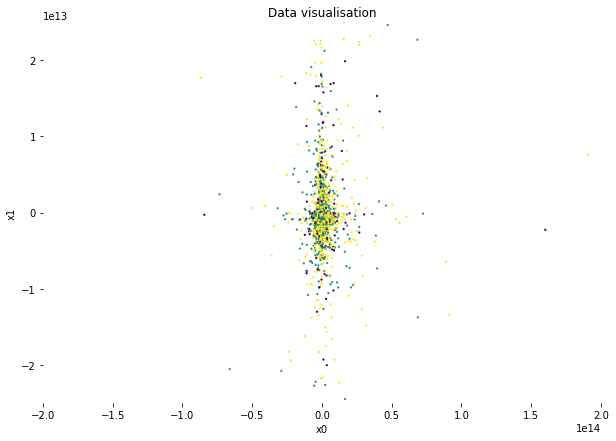

In [35]:
x0 = [x[0] for x in X_train_tsne]
x1 = [x[1] for x in X_train_tsne]
colors = [cm.Vega10((y_) / max(y_train)) for y_ in y_train]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=y_train, edgecolor = 'none', s = 5)
plt.xlabel('x0')
plt.ylabel('x1')
ax.set_xlim([-2e14, 2e14])
ax.set_ylim([-0.25e14, 0.25e14])
plt.title('Data visualisation')

### t-SNE

In [29]:
tsne = TSNE(n_components=2, perplexity=45.0)
X_train_tsne = tsne.fit_transform(X_train, y_train)

In [33]:
X_train_tsne

array([[ -4.63607495e+10,  -1.99778581e+11],
       [ -4.78542810e+11,  -6.37919560e+11],
       [ -4.52857963e+11,  -1.07059978e+11],
       ..., 
       [  2.62081870e+12,   5.92517175e+12],
       [ -9.88432266e+10,  -3.24432415e+11],
       [ -1.83351158e+11,  -1.21652467e+11]])

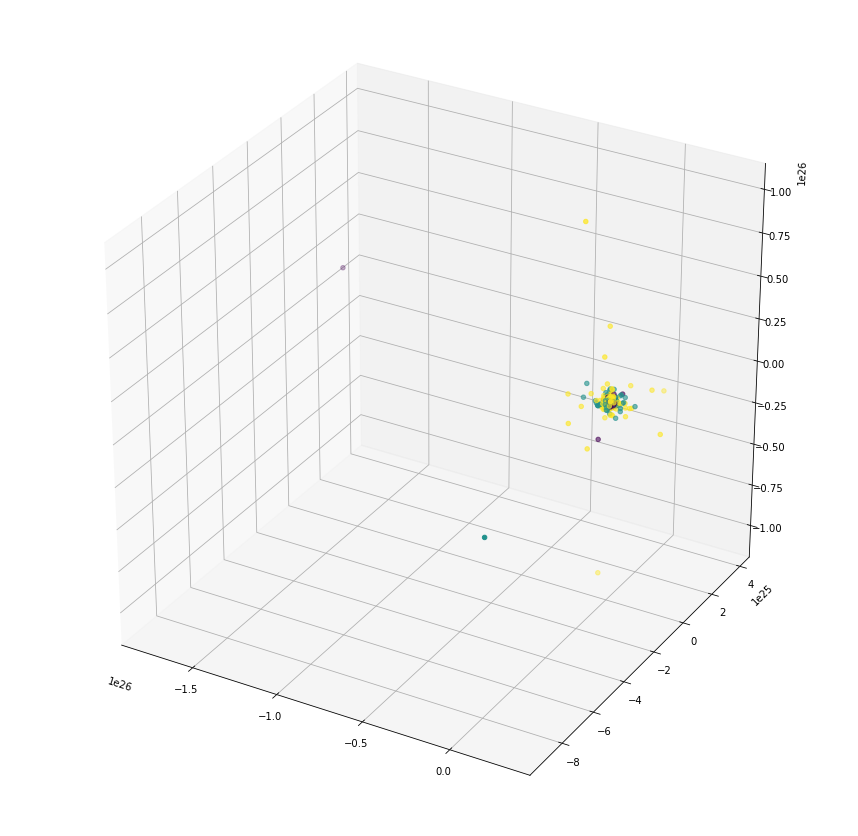

In [27]:
colors = [cm.Vega10((y_) / max(y_train)) for y_ in y_train]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], X_train_tsne[:, 2], c=y_train)
plt.show()

### OneVsRestClassifier

In [28]:
OVR = OneVsRestClassifier(estimator=LogisticRegression())

In [29]:
OVR.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [77]:
y_pred = OVR.predict(X_test)

KeyboardInterrupt: 

In [33]:
print ('Accuracy', list(y_pred == y_test).count(True) / len(y_test))

0.540547749062987

### MLPClassifier

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 1000, 1000), max_iter=1000, activation='logistic')

In [53]:
mlp.fit(X_train_pca, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 1000, 1000), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [55]:
print ('Accuracy', list(mlp.predict(X_test_pca) == y_test).count(True) / len(y_test))

0.5688336117467047

### AdaBoost

In [11]:
AB = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200)

In [13]:
t0 = time()
AB.fit(X_train, y_bin_train)
print ('fitting is done in %s ' % (time() - t0))

fitting is done in 60.81061911582947 


In [15]:
list(AB.predict(X_test) == y_bin_test).count(True) / len(y_bin_test)

0.6199713067232671